Generated with the aid of [Perplexity](https://www.perplexity.ai/search/graph-monthly-mortgage-rates-i-jRKU5XFTSaS.COEnUPmuvg)



In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

class MortgagePlots:
    def __init__(self, csv_file, lag_years=10):
        self.df = pd.read_csv(csv_file)
        self.df['observation_date'] = pd.to_datetime(self.df['observation_date'])
        self.df.set_index('observation_date', inplace=True)
        self.df.sort_index(inplace=True)
        self.lag_weeks = lag_years * 52  # Convert years to weeks
        self.df['MORTGAGE30US_LAGGED'] = self.df['MORTGAGE30US'].shift(self.lag_weeks)
        self.df['Prepay_Incentive'] = (self.df['MORTGAGE30US_LAGGED'] - self.df['MORTGAGE30US']).clip(lower=0)

    def plot_rates(self):
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.plot(self.df.index, self.df['MORTGAGE30US'], label='Original Time Series', linewidth=2)
        ax.plot(self.df.index, self.df['MORTGAGE30US_LAGGED'], 
                label=f'Lagged Time Series ({self.lag_weeks//52} years)', linewidth=2, linestyle='--')
        ax.set_title('30-Year Fixed Mortgage Rates in the US (Monthly)', fontsize=16)
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Mortgage Rate (%)', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()
        plt.close(fig)
        return fig, ax

    def plot_prepay_incentive(self):
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.bar(self.df.index, self.df['Prepay_Incentive'], color='green', label='Prepay Incentive', width=20)
        ax.set_title(f'Incentive to Prepay Mortgage ({self.lag_weeks//52}-Year Lag)', fontsize=16)
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Incentive (%)', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()
        plt.close(fig)
        return fig, ax

    def plot_rates_with_yearly_comparison(self):
        fig, ax = plt.subplots(figsize=(15, 6))

        ax.plot(self.df.index, self.df['MORTGAGE30US'], label='30-Year Fixed Mortgage Rate', color='blue')

        # Calculate the rolling maximum and minimum for the lagged period
        self.df['Max_Lagged'] = self.df['MORTGAGE30US'].rolling(window=self.lag_weeks).max().shift(self.lag_weeks)
        self.df['Min_Lagged'] = self.df['MORTGAGE30US'].rolling(window=self.lag_weeks).min().shift(self.lag_weeks)

        # Shade areas where current rate is higher than the maximum in the lagged period
        ax.fill_between(self.df.index, self.df['MORTGAGE30US'], self.df['Max_Lagged'], 
                        where=(self.df['MORTGAGE30US'] > self.df['Max_Lagged']), color='red', alpha=0.3, 
                        label=f'Higher than max of previous {self.lag_weeks//52} years')

        # Shade areas where current rate is lower than the minimum in the lagged period
        ax.fill_between(self.df.index, self.df['MORTGAGE30US'], self.df['Min_Lagged'], 
                        where=(self.df['MORTGAGE30US'] < self.df['Min_Lagged']), color='green', alpha=0.3, 
                        label=f'Lower than min of previous {self.lag_weeks//52} years')

        # Add text boxes for historic highs and lows
        high_rate_periods = self.df[self.df['MORTGAGE30US'] > self.df['Max_Lagged']]
        low_rate_periods = self.df[self.df['MORTGAGE30US'] < self.df['Min_Lagged']]

        if not high_rate_periods.empty:
            mid_high = high_rate_periods.index[len(high_rate_periods)//2]
            ax.annotate('Historic High Rates', xy=(mid_high, high_rate_periods.loc[mid_high, 'MORTGAGE30US']),
                        xytext=(50, 100), textcoords='offset points', ha='left', va='bottom',
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        if not low_rate_periods.empty:
            mid_low = low_rate_periods.index[len(low_rate_periods)//2]
            ax.annotate('Historic Low Rates', xy=(mid_low, low_rate_periods.loc[mid_low, 'MORTGAGE30US']),
                        xytext=(50, -100), textcoords='offset points', ha='left', va='top',
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        ax.set_title(f'30-Year Fixed Mortgage Rates with {self.lag_weeks//52}-Year Comparison', fontsize=16)
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Mortgage Rate (%)', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

        plt.close(fig)
        return fig, ax

# Usage example:
# plotter = MortgagePlots('MORTGAGE30US.csv', lag_years=10)
# fig1, ax1 = plotter.plot_rates()
# fig2, ax2 = plotter.plot_prepay_incentive()
# fig3, ax3 = plotter.plot_rates_with_yearly_comparison()
# fig1.show()
# fig2.show()
# fig3.show()


In [3]:
current_date = datetime(2025, 2, 16)
plotter = MortgagePlots('MORTGAGE30US.csv')

fig_levels, ax_levels = plotter.plot_rates()

fig_historic_low_high, ax_historic_low_high = plotter.plot_rates_with_yearly_comparison()

fig_incentive, ax_incentive = plotter.plot_prepay_incentive()



Our goal is to create a model
- predicting the probability that a borrower will prepay their mortgage
- fitting the model using the prior 10 years worth of data


# Mortgage rates, with lag

To over-simplify
- we examine the probability of prepayment
- only for mortgages that are exactly 10 years old

We show the current mortgage rate (blue) and the borrower's actual rate (orange).

The borrower has an incentive to prepay
- when the current rate (blue)
- is **lower** than their actual rate (orange)


Here is the data.

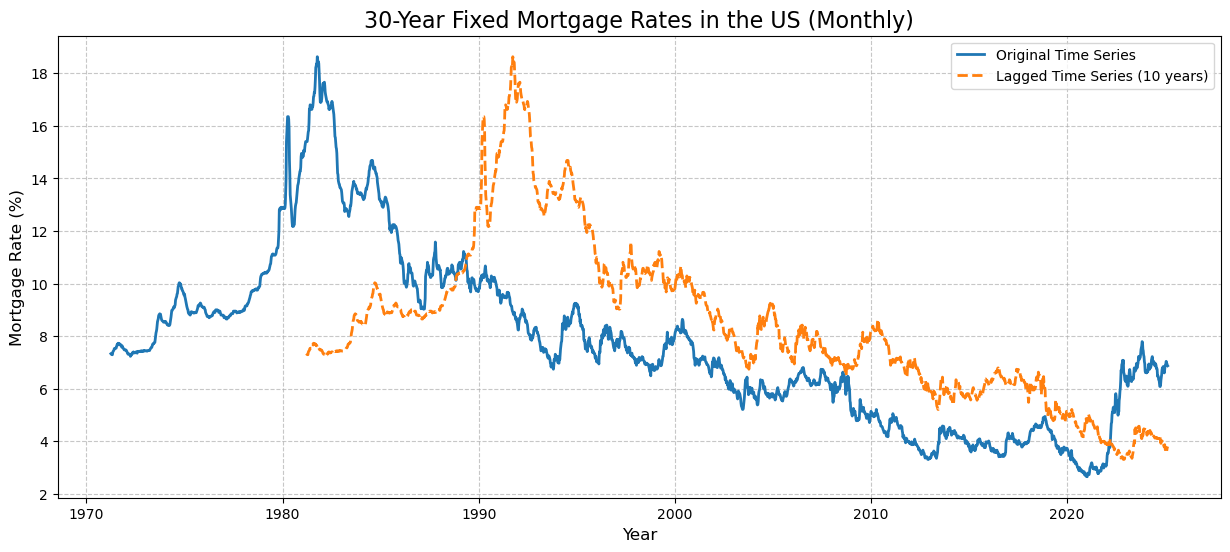

In [4]:
fig_levels

# Incentive: the semantics of prepayment

Let us create a synthetic feature
- the Incentive to prepay

This feature is useful both because
- it captures the **reason** (semantics) why a borrower might prepay
- and is **not** dependent on the level of rates

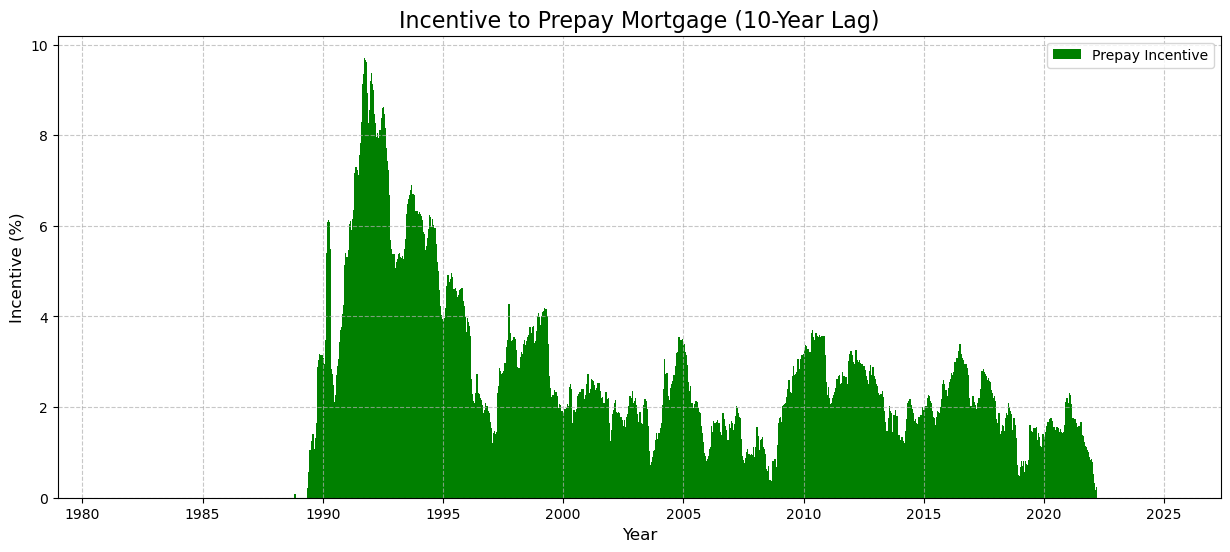

In [5]:
fig_incentive

# Incentive advantage: works even at times when Current Rate is at extremes

Imagine that we try to fit a model at each date
- using training data from the prior 10 years

There will be times (highlighted periods in following plot)
- when the current mortgage rate
- is either at a historic high (red shading) or low (green shading) relative to the training data

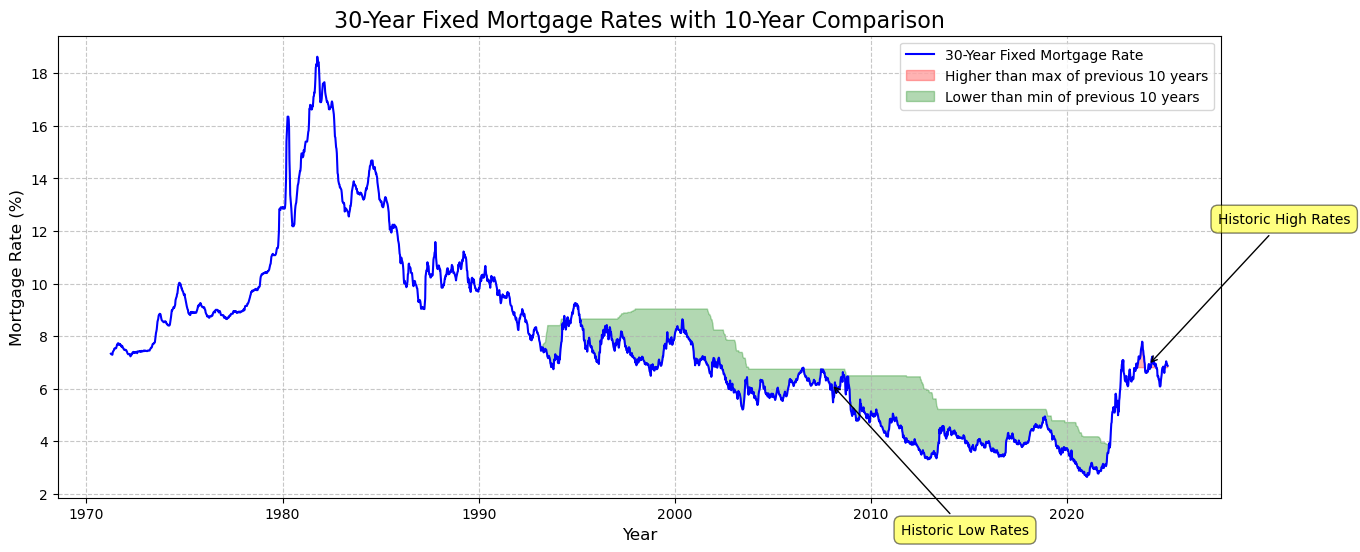

In [6]:
fig_historic_low_high


Using the raw features 
- current mortgage rate
- borrower's actual rate

will violate the Fundamental Theorem of Machine Learning.
- the distribution of mortgage rates is not the same
    - for the training data (prior 10 years)
    - and the out of sample period

In [7]:
print("Done")

Done
